# Tarea 2: NLP, RNNs y Transformer

In [568]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [569]:
import re

import numpy as np              # Procesamiento numérico
import pandas as pd             # Manipulación de conjuntos de datos
import matplotlib.pyplot as plt # Gráficos

import matplotlib.ticker as ticker

from tqdm import tqdm

from torch.utils.data import DataLoader, Subset

import torch
import torch.nn as nn
import torch.nn.functional as F

## Carga del dataset

Para la tarea se utilizará el dataset IMDB, el cual consiste en reseñas de películas con sus respectivas etiquetas de si es una reseña positiva o negativa.

El dataset se encuentra disponible en HuggingFace, asi que se puede cargar directamente.

**Nota:** Para descargar el dataset se tiene que instalar previamente la librería "datasets"

In [570]:
# # installing datasets package
# !pip install datasets

In [571]:
from datasets import load_dataset

In [572]:
dataset = load_dataset("stanfordnlp/imdb")

Using the latest cached version of the dataset since stanfordnlp/imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at C:\Users\Bruno\.cache\huggingface\datasets\stanfordnlp___imdb\plain_text\0.0.0\e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Sat May 11 19:55:56 2024).


In [573]:
data_train = pd.DataFrame(dataset["train"])
data_test = pd.DataFrame(dataset["test"])

# shuffle datasets

data_train = data_train.sample(frac=1).reset_index(drop=True)
data_test = data_test.sample(frac=1).reset_index(drop=True)

data_train.head()

,text,label
0,Very good martial arts film and Jet Li is the ...,1
1,As an old white housewife I can still apprecia...,1
2,Cash (Now played by Khrystyne Haje in for Ange...,0
3,This is a classic example of an increasing pro...,0
4,Lock Up Your Daughters is one of the best high...,1


In [574]:
# fraction dataset

fraction = 1
data_train = data_train.sample(frac=fraction).reset_index(drop=True)
data_test = data_test.sample(frac=fraction).reset_index(drop=True)

In [575]:
# tokenization
from nltk.tokenize import word_tokenize
import nltk
from bs4 import BeautifulSoup

nltk.download('punkt')

token_data_train = data_train.copy()
token_data_test = data_test.copy()

def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text(separator=" ")
    # Remove special characters and multiple spaces
    text = re.sub(r'[^a-zA-Z0-9\s.,]', ' ', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Convert text to lowercase
    text = text.lower()
    return text.strip()

token_data_train["text"] = token_data_train["text"].apply(clean_text)
token_data_test["text"] = token_data_test["text"].apply(clean_text)

token_data_train["text"] = token_data_train["text"].apply(word_tokenize)
token_data_test["text"] = token_data_test["text"].apply(word_tokenize)

token_data_train.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bruno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Bruno\AppData\Local\Temp\ipykernel_4184\1763248502.py:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text(separator=" ")


,text,label
0,"[peter, ustinov, plays, an, embezzler, who, is...",1
1,"[i, wait, for, each, new, episode, ,, each, re...",1
2,"[i, saw, this, movie, thinking, that, it, woul...",0
3,"[a, scientist, and, his, girl, friend, are, ou...",0
4,"[i, really, tried, to, like, this, movie, but,...",0


In [576]:
# vocabulary
from collections import Counter

vocab = Counter()

for text in token_data_train["text"]:
    vocab.update(text)

# most common words
most_common_words = vocab.most_common(20000)
print(most_common_words)

# vocab size
vocabulary_size = len(most_common_words)
num_embeddings = vocabulary_size + 2
print(f"Vocabulary size: {vocabulary_size}")

[('the', 336136), (',', 275888), ('.', 269453), ('and', 164054), ('a', 162713), ('of', 145851), ('to', 135700), ('is', 107326), ('it', 96103), ('in', 93922), ('i', 86862), ('this', 75805), ('that', 73249), ('s', 62902), ('was', 48198), ('as', 46908), ('for', 44318), ('with', 44115), ('movie', 43934), ('but', 42513), ('film', 40097), ('you', 34226), ('on', 34187), ('t', 33595), ('not', 31708), ('he', 30076), ('are', 29436), ('his', 29352), ('have', 27728), ('be', 26949), ('one', 26752), ('all', 23933), ('at', 23500), ('they', 22855), ('by', 22538), ('an', 21556), ('who', 21429), ('so', 20576), ('from', 20487), ('like', 20269), ('there', 18762), ('her', 18405), ('or', 18005), ('just', 17762), ('about', 17365), ('out', 17100), ('has', 16790), ('if', 16747), ('what', 16152), ('can', 15773), ('some', 15736), ('good', 15113), ('more', 14246), ('she', 14184), ('when', 14163), ('very', 14060), ('up', 13284), ('time', 12700), ('no', 12685), ('even', 12637), ('my', 12488), ('would', 12434), ('wh

In [577]:
# Define the vocabulary size based on the most common words
vocabulary_size = 20000

# Get the most common words up to the specified vocabulary size
most_common_words = vocab.most_common(vocabulary_size)

# Create word-to-index mapping with padding and unknown tokens
word_to_index = {word: index + 2 for index, (word, count) in enumerate(most_common_words)}
word_to_index["<PAD>"] = 0
word_to_index["<UNK>"] = 1

# Create index-to-word mapping
index_to_word = {index: word for word, index in word_to_index.items()}
index_to_word[0] = "<PAD>"
index_to_word[1] = "<UNK>"

# Define a function to encode text using the word-to-index mapping
def encode_text(text):
    return [word_to_index.get(word, 1) for word in text]

# Apply the encoding function to the 'text' column of token_data_train and token_data_test
token_data_train["text"] = token_data_train["text"].apply(encode_text)
token_data_test["text"] = token_data_test["text"].apply(encode_text)

# Display the modified token_data_train
print(token_data_train.head())

                                                text  label
0  [798, 4988, 301, 37, 15985, 38, 9, 45, 397, 47...      1
1  [12, 843, 18, 257, 165, 389, 3, 257, 153, 512,...      1
2  [12, 220, 13, 20, 532, 14, 10, 63, 31, 32, 7, ...      0
3  [6, 1597, 5, 29, 241, 447, 28, 47, 1943, 56, 2...      0
4  [12, 67, 792, 8, 41, 13, 20, 21, 11, 2, 133, 1...      0


In [578]:
# padding

text_max_length = np.max(token_data_train["text"].apply(len))
text_mean_length = int(np.mean(token_data_train["text"].apply(len)))
text_median_length = int(np.median(token_data_train["text"].apply(len)))

print(f"Max length: {text_max_length}")
print(f"Mean length: {text_mean_length}")
print(f"Median length: {text_median_length}")

def pad_text(text, length):
    return text[:length] if len(text) > length else text + [0] * (length - len(text))

token_data_train["text"] = token_data_train["text"].apply(pad_text, length=text_median_length//4)
token_data_test["text"] = token_data_test["text"].apply(pad_text, length=text_max_length)

token_data_train.head()

Max length: 2699
Mean length: 260
Median length: 194


,text,label
0,"[798, 4988, 301, 37, 15985, 38, 9, 45, 397, 47...",1
1,"[12, 843, 18, 257, 165, 389, 3, 257, 153, 512,...",1
2,"[12, 220, 13, 20, 532, 14, 10, 63, 31, 32, 7, ...",0
3,"[6, 1597, 5, 29, 241, 447, 28, 47, 1943, 56, 2...",0
4,"[12, 67, 792, 8, 41, 13, 20, 21, 11, 2, 133, 1...",0


In [579]:
# create validation set

validation_size = 0.2
validation_samples = int(len(token_data_train) * validation_size)

final_val = token_data_train[:validation_samples]
final_train = token_data_train[validation_samples:]
final_test = token_data_test

In [580]:
final_train.reset_index(drop=True, inplace=True)
final_train.head()

,text,label
0,"[1829, 5, 1829, 16, 32, 7, 12967, 4136, 15, 29...",1
1,"[13, 22, 16, 546, 21, 2323, 5, 2, 116, 401, 1,...",0
2,"[90, 8, 1578, 364, 9412, 81, 9, 6, 897, 22, 4,...",1
3,"[1593, 5, 605, 3, 12, 118, 13, 20, 4, 17, 52, ...",1
4,"[450, 24, 6, 528, 4845, 647, 36, 32, 59, 241, ...",0


In [581]:
final_train

,text,label
0,"[1829, 5, 1829, 16, 32, 7, 12967, 4136, 15, 29...",1
1,"[13, 22, 16, 546, 21, 2323, 5, 2, 116, 401, 1,...",0
2,"[90, 8, 1578, 364, 9412, 81, 9, 6, 897, 22, 4,...",1
3,"[1593, 5, 605, 3, 12, 118, 13, 20, 4, 17, 52, ...",1
4,"[450, 24, 6, 528, 4845, 647, 36, 32, 59, 241, ...",0
...,...,...
19995,"[799, 3, 26, 53, 4, 10, 511, 47, 222, 3, 21, 1...",0
19996,"[13, 9, 6, 924, 20, 18, 351, 450, 24, 2, 14405...",1
19997,"[17321, 15580, 169, 11861, 1209, 3, 5, 6597, 1...",0
19998,"[50, 123, 1295, 160, 2871, 8608, 68, 11, 1757,...",0


 Por motivos de costo computacional y tiempo de entrenamiento, para la tarea pueden considerar una proporción del dataset,  por ejemplo el 10%. Pero tenga en consideración que si el tamaño del dataset es muy pequeño el rendimiento del modelo se verá afectado negativamente.

In [582]:
# PyTorch datasets

from torch.utils.data import Dataset

class IMDBDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data["text"][index]), torch.tensor(self.data["label"][index])
    
train_dataset = IMDBDataset(final_train)
val_dataset = IMDBDataset(final_val)
test_dataset = IMDBDataset(final_test)

# Report split sizes
print('Training set has {} instances'.format(len(final_train)))
print('Validation set has {} instances'.format(len(final_val)))
print('Test set has {} instances'.format(len(final_test)))

# PyTorch dataloaders

batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training set has 20000 instances
Validation set has 5000 instances
Test set has 25000 instances


In [583]:
# # NO

# import random

# # percentage
# ratio = 0.5
# dataset_size = len(token_data_train)
# train_size = int(dataset_size * ratio * 0.8)
# val_size = int(dataset_size * ratio * 0.2)
# test_size = int(dataset_size * ratio)

# train_subset = Subset(token_data_train, np.arange(0, train_size))
# val_subset = Subset(token_data_train, np.arange(train_size, train_size + val_size))
# test_subset = Subset(token_data_test, np.arange(test_size))

## Parte 1: Redes Neuronales Recurrentes (RNNs)

### Actividad 1

Responda las siguientes preguntas:


*   ¿Cuáles son las principales características de las redes neuronales recurrentes?

    **Respuesta:** Las redes neuronales recurrentes, como su nombre indica, poseen conexiones recurrentes
    lo que permite que la red mantenga una memoria de los datos que ha procesado previamente,
    de forma que el _output_ en un estado particual esta influenciado no solo por su _input_ actual
    sino también por los _inputs_ previos.
    
    Las RNN tienen la capacidad de recibir _inputs_ de longitud variable y producir _outputs_ de longitud variable.

*   ¿Cuáles son las desventajas y limitaciones de las redes RNNs?

    **Respuesta:** Las RNNs sufren del problema de desvanecimiento y explosión del gradiente, lo que
    dificulta el entrenamiento de la red. Además, las RNNs tienen dificultades para mantener
    la memoria a largo plazo, lo que limita su capacidad para recordar información relevante
    de _inputs_ muy antiguos. Por el contrario, las RNNs también tienen problemas para olvidar
    información irrelevantes de _inputs_ recientes que no son relevantes para el _output_.

*   Menciona y describa brevemente al menos dos variantes a la arquitectura de RNNs simples.

    **Respuesta:** LSTM: Las redes LSTM (Long Short-Term Memory) son una variante de las RNNs que
    intentan solucionar el problema de la memoria a largo plazo. Las LSTM poseen una estructura
    más compleja que las RNNs tradicionales, con una estructura de celdas que permiten mantener
    la memoria a largo plazo y olvidar información irrelevante.

    GRU: Las redes GRU (Gated Recurrent Unit) son una variante de las RNNs que intentan simplificar
    la estructura de las LSTM, eliminando la estructura de celdas y manteniendo solo las puertas
    de olvido y actualización. Las GRU son más simples que las LSTM y tienen menos parámetros,
    lo que las hace más fáciles de entrenar y menos propensas al sobreajuste.

    Modelos de atención: Los modelos de atención son una variante de las RNNs que permiten
    que la red se enfoque en partes específicas de la secuencia de _inputs_ para generar el _output_,
    asignando pesos a los _inputs_ en vez de asignar el mismo peso a todos los _inputs_ como lo hacen
    las RNNs tradicionales. 

### Actividad 2

Implemente una red RNN simple y realice su entrenamiento con el dataset preprocesado. Para el pre-procesamiento use el método de la Actividad 1.

La siguiente celda contiene el esqueleto de la red. Puede usarlo como referencia para su implementación o realizar una propia.

In [626]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, dropout=0.2):
        super(SimpleRNN, self).__init__()
        
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True, nonlinearity='relu', dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        
        # RNN
        out, hidden = self.rnn(x)
        
        out = self.fc(out[:, -1, :])
        
        return out

In [627]:
simple_model = SimpleRNN(num_embeddings, 128, 128, 1, dropout=0.2)

c:\Users\Bruno\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [628]:
criterion = nn.BCEWithLogitsLoss()
lr = 0.005
optimizer = torch.optim.Adam(simple_model.parameters(), lr=lr)

In [629]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simple_model.to(device)

SimpleRNN(
  (embedding): Embedding(20002, 128)
  (rnn): RNN(128, 128, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [630]:
def train(num_epochs, model, criterion, optimizer, train_dataloader, val_dataloader):
    losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        for i, (texts, labels) in enumerate(tqdm(train_dataloader)):
            if torch.isnan(texts).any() or torch.isinf(texts).any():
                print(f"Found NaN or inf in texts at iteration {i}")
            if torch.isnan(labels).any() or torch.isinf(labels).any():
                print(f"Found NaN or inf in labels at iteration {i}")
            if (texts >= num_embeddings).any():
                print(f"Found out-of-range values in texts at iteration {i}")
            texts = texts.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            output = model(texts)
            # print(output)
            output = output.squeeze()  # Remove the extra dimension from the output
            # print(output, labels.float())

            loss = criterion(output, labels.float())  # Compute the loss
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Apply gradient clipping
            optimizer.step()

        losses.append(loss.item())
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

        model.eval()

        with torch.no_grad():
            for i, (texts, labels) in enumerate(tqdm(val_dataloader)):
                texts = texts.to(device)
                labels = labels.to(device)

                output = model(texts)
                output = output.squeeze()

                val_loss = criterion(output, labels.float())

        val_losses.append(val_loss.item())
        print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch+1, num_epochs, val_loss.item()))

    return (losses, val_losses)

In [631]:
losses, val_losses = train(5, simple_model, criterion, optimizer, train_dataloader, val_dataloader)

100%|██████████| 157/157 [00:01<00:00, 106.73it/s]


Epoch [1/5], Loss: 0.7220


100%|██████████| 40/40 [00:00<00:00, 254.78it/s]


Epoch [1/5], Validation Loss: 0.6653


100%|██████████| 157/157 [00:01<00:00, 115.19it/s]


Epoch [2/5], Loss: 0.5202


100%|██████████| 40/40 [00:00<00:00, 239.52it/s]


Epoch [2/5], Validation Loss: 0.6468


100%|██████████| 157/157 [00:01<00:00, 108.80it/s]


Epoch [3/5], Loss: 0.4446


100%|██████████| 40/40 [00:00<00:00, 196.08it/s]


Epoch [3/5], Validation Loss: 0.6902


100%|██████████| 157/157 [00:01<00:00, 105.44it/s]


Epoch [4/5], Loss: 0.5733


100%|██████████| 40/40 [00:00<00:00, 223.47it/s]


Epoch [4/5], Validation Loss: 0.6284


100%|██████████| 157/157 [00:01<00:00, 103.02it/s]


Epoch [5/5], Loss: 0.3548


100%|██████████| 40/40 [00:00<00:00, 181.00it/s]

Epoch [5/5], Validation Loss: 1.0001


In [634]:
# PATH = './simple_rnn.pth'
# torch.save(simple_model.state_dict(), PATH)

In [591]:
# PATH = './simple_rnn.pth'
# simple_model = SimpleRNN(num_embeddings, 128, 128, 1)
# simple_model.load_state_dict(torch.load(PATH))
# simple_model.to(device)

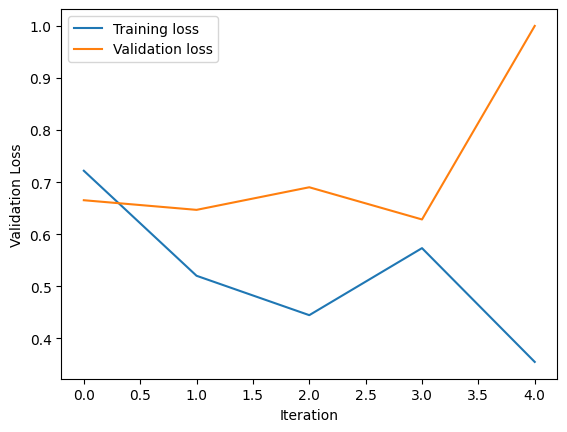

In [632]:
# plot losses

def plot(losses, val_losses):

    plt.plot(losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.legend()

    plt.xlabel("Iteration")
    plt.ylabel("Validation Loss")

    plt.show()

plot(losses, val_losses)

In [633]:
# Test accuracy

def test(model, dataloader):

    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for texts, labels in tqdm(dataloader):
            texts = texts.to(device)
            labels = labels.to(device)

            output = model(texts)
            output = output.squeeze()

            predictions = torch.round(torch.sigmoid(output))

            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    accuracy = correct / total
    print(f"Test accuracy: {accuracy * 100:.2f}%")

test(simple_model, test_dataloader)

100%|██████████| 196/196 [00:13<00:00, 14.60it/s]

Test accuracy: 74.06%


### Actividad 3

Implemente una red variante al RNN clásico, como un LSTM, GRU, Bi-LSTM, entre otros. Realice el entrenamiento del modelo con el mismo dataset. Realice un breve análisis sobre las diferencias en términos de los resultados, tiempo de ejecución y aspectos que le parezcan relevantes, entre la red implementada en la actividad previa y la red implementada en esta actividad.

In [691]:
class VariantRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, dropout=0.2):
        super(VariantRNN, self).__init__()
        
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.GRU(embedding_size, hidden_size, batch_first=True, num_layers=1, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        
        # RNN
        out, hidden = self.rnn(x)
        
        out = self.fc(out[:, -1, :])
        
        return out

In [692]:
variant_model = VariantRNN(num_embeddings, 128, 128, 1, dropout=0.2)
variant_model.to(device)

VariantRNN(
  (embedding): Embedding(20002, 128)
  (rnn): GRU(128, 128, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [693]:
criterion = nn.BCEWithLogitsLoss()
lr = 0.005
optimizer = torch.optim.Adam(variant_model.parameters(), lr=lr)

In [694]:
losses, val_losses = train(5, variant_model, criterion, optimizer, train_dataloader, val_dataloader)

100%|██████████| 157/157 [00:01<00:00, 98.43it/s] 


Epoch [1/5], Loss: 0.5782


100%|██████████| 40/40 [00:00<00:00, 235.29it/s]


Epoch [1/5], Validation Loss: 0.5996


100%|██████████| 157/157 [00:01<00:00, 102.82it/s]


Epoch [2/5], Loss: 0.6409


100%|██████████| 40/40 [00:00<00:00, 223.46it/s]


Epoch [2/5], Validation Loss: 0.5084


100%|██████████| 157/157 [00:01<00:00, 100.45it/s]


Epoch [3/5], Loss: 0.3730


100%|██████████| 40/40 [00:00<00:00, 224.72it/s]


Epoch [3/5], Validation Loss: 0.6388


100%|██████████| 157/157 [00:01<00:00, 98.99it/s]


Epoch [4/5], Loss: 0.2999


100%|██████████| 40/40 [00:00<00:00, 221.00it/s]


Epoch [4/5], Validation Loss: 0.9923


100%|██████████| 157/157 [00:01<00:00, 96.73it/s]


Epoch [5/5], Loss: 0.1780


100%|██████████| 40/40 [00:00<00:00, 218.58it/s]

Epoch [5/5], Validation Loss: 1.0751


In [697]:
# PATH = './variant_rnn.pth'
# torch.save(variant_model.state_dict(), PATH)

In [616]:
# PATH = './variant_rnn.pth'
# variant_model = VariantRNN(num_embeddings, 128, 128, 1)
# variant_model.load_state_dict(torch.load(PATH))
# variant_model.to(device)

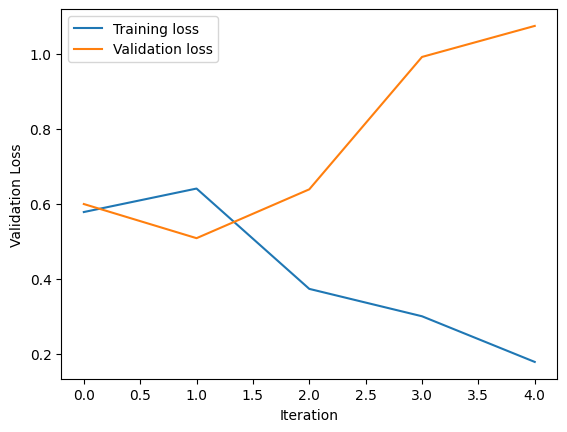

In [695]:
plot(losses, val_losses)

In [696]:
test(variant_model, test_dataloader)

100%|██████████| 196/196 [00:14<00:00, 13.96it/s]

Test accuracy: 80.34%


#### SimpleRNN vs VariantRNN



## Parte 2: Transformer

### Actividad 4

Responda las siguientes preguntas:



*   ¿Cuáles son los principales aspectos de las redes Transformer?
¿Qué desafíos específicos de las RNNs intenta superar la arquitectura de los Transformers?

    **Respuesta:**....

*   ¿Cuáles son las diferencias entre las capas cross-attention y self-attention?

    **Respuesta:**....

*   ¿Cuáles son las principales características del encoder y el decoder de una red Transformer?

    **Respuesta:**....

*   ¿En qué casos se aplica modelos de tipo encoder?. En qué casos se aplica modelos de tipo decoder?. ¿En qué casos se aplica modelos de tipo encoder decoder?. Responda y justifique su respuesta brevemente.

    **Respuesta:**....

### Actividad 5

En particular, la tarea será sobre generación de reseñas. Es decir que tendrán que implementar una red Transformer y entrenarla con el dataset IMDB para generar texto de reseñas de películas.

A medida que progresa el entrenamiento, muestre algunas instancias de salida del texto generado por el modelo. Para ello considere los puntos inicial, intermedio y final del entrenamiento. Realice un análisis sobre el texto generado y explique brevemente cómo el modelo es capaz de generar texto de reseñas.

Es importante que argumente su elección de los parámetros e hiperparámetros que vaya a utilizar, tales como: cantidad de capas, cantidad de neuronas por capa, función de activación, función de pérdida, etc. En particular, describa el método utilizado para la tokenización de los datos.

In [ ]:
class MyModel(nn.Module):
   def __init__(self):
        super().__init__()
        pass

In [ ]:
def train(model):
  pass

La siguiente celda es un ejemplo del entrenamiento de su modelo y de la generación de reseñas que realiza su modelo entrenado. En este caso se muestra la generación de 2000 tokens.

In [ ]:
model = MyModel()

train(model)

num_tokens = 2000

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=num_tokens)[0].tolist()))

0.224306 M parameters
step 0: train loss 5.3014, val loss 5.3014
step 100: train loss 2.7339, val loss 2.7166
step 200: train loss 2.5480, val loss 2.5588
step 300: train loss 2.4732, val loss 2.4783
step 400: train loss 2.3983, val loss 2.3997
step 500: train loss 2.3159, val loss 2.3250
step 600: train loss 2.2822, val loss 2.2755
step 700: train loss 2.2273, val loss 2.2159
step 800: train loss 2.1654, val loss 2.1702
step 900: train loss 2.1472, val loss 2.1538
step 1000: train loss 2.1127, val loss 2.1100
step 1100: train loss 2.0843, val loss 2.0968
step 1200: train loss 2.0706, val loss 2.0647
step 1300: train loss 2.0495, val loss 2.0576
step 1400: train loss 2.0166, val loss 2.0264
step 1500: train loss 2.0031, val loss 1.9983
step 1600: train loss 1.9816, val loss 1.9836
step 1700: train loss 1.9620, val loss 1.9739
step 1800: train loss 1.9528, val loss 1.9667
step 1900: train loss 1.9252, val loss 1.9404
step 2000: train loss 1.9206, val loss 1.9348
step 2100: train loss 1.

In [ ]:
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

Review: (TH Of E NOU'NYTN CE) No jealloa girl suwital. Unounder. I gon that HANEY SENK. SHEEG. All is helpinnes, that is job and AltohCRE: Fronk AGE A Sdenterns Review: Lusbe Allf Flaegray Ram-, high scist, butment was little nothim to yet. There been turn the good much, and thought be ver factuul to one yous heldined expy woutch be in creadity for Orché no culla real on monstanshing takeour ly grourie and some and panter and about my about crist? Well by infully. She Nebs and I wald they MTIE FOMD, Alexra TV Oh- hard, it those diffect, tries and Fene, more get yong trody or bad a torie writh this, you pay.<br /> /><br />I `00 a liude show ence have unding the tinfully. He right Combering Jet encesten with (looking, stakes) is a lost get it on in the film, but that stophiles it the bere I watch zitious that scene the `T.. Nonzeplay? The goals bad do - in clasks of his for than asks and to but. On bout, doire and relazing, the and the criseum and tract crimitly watchonde thip is the sur

### Actividad 6

A partir del modelo generativo de la anterior actividad, realice los ajustes necesarios al modelo para mejorar la calidad de las reseñas generadas. Se espera que el modelo sea capaz de generar reseñas de mejor calidad en comparación a la actividad previa. Para ello, investigue y agregue otros datasets públicos de reseñas de películas u otro tipo.